In [1]:
import os
import sys
import json
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from glob import glob
from nilearn import plotting
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix

In [2]:
task_label = 'tonecat'

project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
#bidsroot = os.path.join(project_dir,'data_bids')
bidsroot = os.path.join(project_dir,'data_bids_noIntendedFor')
deriv_dir = os.path.join(project_dir, 'derivatives', 'fmriprep_noSDC')

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')
if not os.path.exists(nilearn_dir):
        os.makedirs(nilearn_dir)

## Second-level analyses

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

### Build the group-level design matrix

#### Read the `participants.tsv` file from the BIDS root directory

In [73]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT01', 'sub-FLT14', 'sub-FLT15', 'sub-FLT16', 'sub-FLT24']
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index, inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], ignore_index=True, inplace=True)

In [76]:
print(participants_df)

   participant_id  age sex         group
0       sub-FLT02   21   F  non-Mandarin
1       sub-FLT03   25   F      Mandarin
2       sub-FLT04   21   F  non-Mandarin
3       sub-FLT05   26   M      Mandarin
4       sub-FLT06   21   F  non-Mandarin
5       sub-FLT07   22   M      Mandarin
6       sub-FLT08   23   F      Mandarin
7       sub-FLT09   30   F  non-Mandarin
8       sub-FLT10   23   F      Mandarin
9       sub-FLT11   20   F  non-Mandarin
10      sub-FLT12   20   F  non-Mandarin
11      sub-FLT13   23   F  non-Mandarin


In [77]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

In [78]:
print(sub_list_mand)

['sub-FLT03', 'sub-FLT05', 'sub-FLT07', 'sub-FLT08', 'sub-FLT10']


In [79]:
print(sub_list_nman)

['sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11', 'sub-FLT12', 'sub-FLT13']


#### Create design matrixes

In [108]:
# difference between groups
subjects_label = list(participants_df.participant_id)
groups_label = list(participants_df.group)
design_mat_groupdiff = pd.DataFrame({'group': groups_label,
                                    'intercept': np.zeros(len(subjects_label))})

design_mat_groupdiff['group'].loc[design_mat_groupdiff['group'] == 'Mandarin'] = 1
design_mat_groupdiff['group'].loc[design_mat_groupdiff['group'] == 'non-Mandarin'] = 0
design_mat_groupdiff = design_mat_groupdiff.astype('int')
print(design_mat_groupdiff)

    group  intercept
0       0          0
1       1          0
2       0          0
3       1          0
4       0          0
5       1          0
6       1          0
7       0          0
8       1          0
9       0          0
10      0          0
11      0          0


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [99]:
# overall population (one-sample test)
n_subjects = len(participants_df)
design_matrix = pd.DataFrame([1] * n_subjects, columns=['intercept'])

In [100]:
# single-group
design_mat_mand = pd.DataFrame([1] * len(sub_list_mand), columns=['intercept'])
design_mat_nman = pd.DataFrame([1] * len(sub_list_nman), columns=['intercept'])

### Get files

In [101]:
contrast_label = 'sound'
fwhm = 4.5
space_label = 'MNI152NLin2009cAsym'
l1_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 'level-1_fwhm-%.02f'%fwhm)
l1_fnames = sorted(glob(l1_dir+'/sub-*_space-%s/run-all/*%s_map-beta.nii.gz'%(space_label, contrast_label)))


In [102]:
l1_fnames_groupdiff = [sorted(glob(l1_dir+'/%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in subjects_label]

l1_fnames_mand = [sorted(glob(l1_dir+'/%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_mand]
l1_fnames_nman = [sorted(glob(l1_dir+'/%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_nman]

### Mandarin-speaking group:

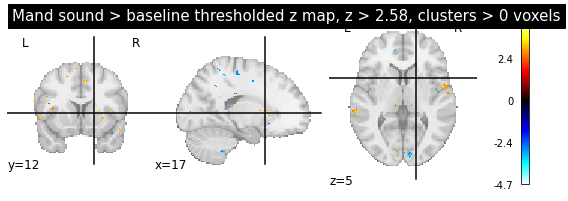

In [111]:
second_level_model = SecondLevelModel().fit(l1_fnames_mand, design_matrix=design_mat_mand)

z_map = second_level_model.compute_contrast(output_type='z_score')

from nilearn.image import threshold_img
threshold = 2.58
cthresh=0
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

### Non-Mandarin speaking group:

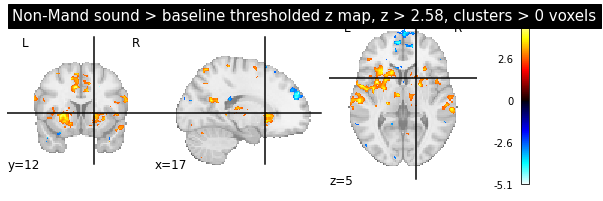

In [52]:
second_level_model = SecondLevelModel().fit(l1_fnames_nman, design_matrix=design_mat_nman)

z_map = second_level_model.compute_contrast(output_type='z_score')

from nilearn.image import threshold_img
threshold = 2.58
cthresh=0
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Non-Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

### Group differences

In [110]:
second_level_model = SecondLevelModel().fit(l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)

z_map = second_level_model.compute_contrast(second_level_contrast='group', output_type='z_score')

from nilearn.image import threshold_img
threshold = 2.58
cthresh=0
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

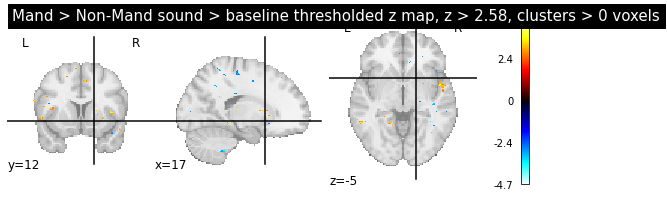

In [113]:
plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,-5], 
    title='Mand > Non-Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

### All participants

In [ ]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel().fit(l1_fnames, design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(output_type='z_score')

from nilearn import plotting
display = plotting.plot_stat_map(z_map, title='Raw z map - %s > baseline'%contrast_label)

In [ ]:
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='%s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

In [ ]:
from nilearn.glm import threshold_stats_img
fpr_alpha = .01
cthresh = 10
thresholded_map1, \
    threshold1 = threshold_stats_img(
                                    z_map,
                                    alpha=fpr_alpha,
                                    height_control='fpr',
                                    cluster_threshold=cthresh,
                                    two_sided=True,
                                    )
plotting.plot_stat_map(
    thresholded_map1, cut_coords=display.cut_coords, threshold=threshold1,
    title='%s > baseline thresholded z map, fpr <%.03f, clusters > %d voxels'%(contrast_label, fpr_alpha, cthresh))
print(threshold1)

In [ ]:
thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)

plotting.plot_stat_map(thresholded_map2, cut_coords=display.cut_coords,
                       title='%s > baseline thresholded z map, expected fdr = .05'%contrast_label,
                       threshold=threshold2)

### Surface plots

In [114]:
from nilearn import datasets, surface

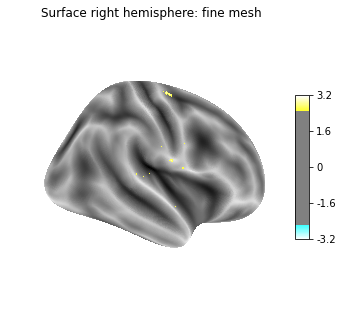

In [115]:
big_fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
big_texture = surface.vol_to_surf(z_map, big_fsaverage.pial_right)

plotting.plot_surf_stat_map(big_fsaverage.infl_right,
                            big_texture, hemi='right', colorbar=True,
                            title='Surface right hemisphere: fine mesh',
                            threshold=2.58, bg_map=big_fsaverage.sulc_right)
plotting.show()

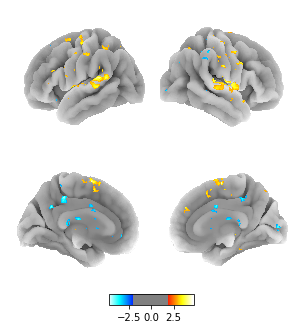

In [119]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=1.96, #2.58,
                          colorbar=True)
plotting.show()

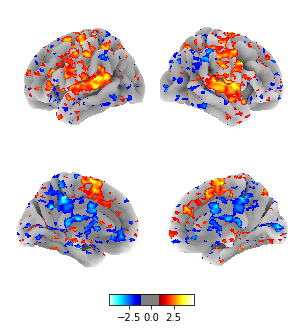

In [117]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=1, #2.58,
                          colorbar=True)
plotting.show()